In [1]:
!pip install torch torchvision transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import torch.nn as nn
import os
import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Using models from compressai

In [6]:
!pip install compressai torch

  Using cached compressai-1.2.6.tar.gz (163 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 965.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00
  Created wheel for compressai: filename=compressai-1.2.6-cp310-cp310-linux_x86_64.whl size=400491 sha256=3501ecfb2b036ba793bd27c38abfa6b5111fb3270de743dbd5eefff85edfc841
  Stored in directory: /root/.cache/pip/wheels/b3/e1/85/87edc5d40a531877f35ba1cfc8f66e2e76d49d4845f57c0f46
Successfully built compressai


In [7]:
import sys

def deep_getsizeof(o, ids):
    """Recursively finds size of objects in bytes."""
    size = sys.getsizeof(o)
    if id(o) in ids:
        return 0

    ids.add(id(o))

    if isinstance(o, dict):
        size += sum(deep_getsizeof(k, ids) + deep_getsizeof(v, ids) for k, v in o.items())
    elif isinstance(o, (list, tuple, set, frozenset)):
        size += sum(deep_getsizeof(item, ids) for item in o)
    elif hasattr(o, '__dict__'):
        size += deep_getsizeof(o.__dict__, ids)
    elif hasattr(o, '__iter__') and not isinstance(o, (str, bytes, bytearray)):
        size += sum(deep_getsizeof(i, ids) for i in o)

    return size

def total_size_of_dictionary(d):
    """Calculates total size of a dictionary, including its contents."""
    return deep_getsizeof(d, set())

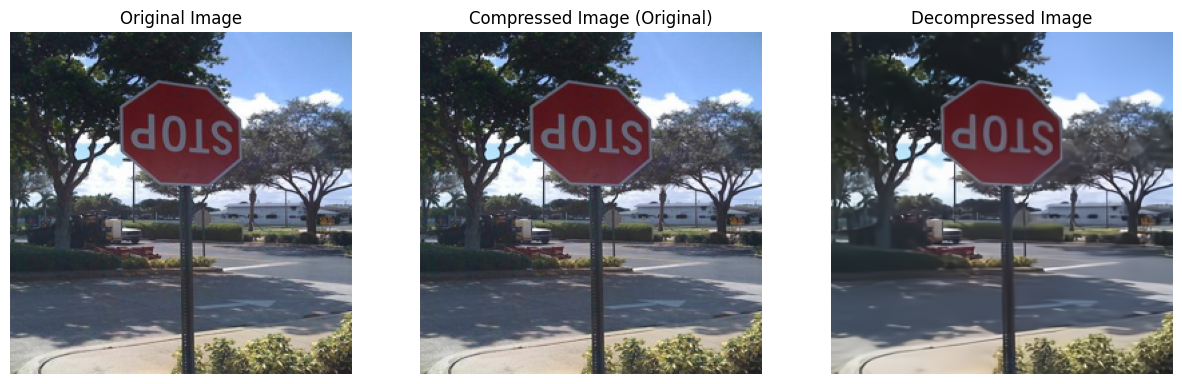

Original image shape: torch.Size([1, 3, 256, 256])
Compressed size (bits): 42464
Number of pixels: 65536
BPP: 0.64794921875


In [9]:
import torch
from compressai.zoo import cheng2020_anchor
from PIL import Image
import numpy as np


img = Image.open('/content/drive/My Drive/Final Project/datasets/images/COCO_val2014_000000000724.jpg').convert('RGB')

img = img.resize((256, 256))
img = np.array(img).astype(np.float32) / 255.0
img_size = img.nbytes
img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = cheng2020_anchor(quality=4, pretrained=True).eval().to(device)

with torch.no_grad():
    img_tensor = img_tensor.to(device)
    out_enc = model.compress(img_tensor)

out_dec = model.decompress(out_enc['strings'], out_enc['shape'])

reconstructed_image = out_dec['x_hat'].clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
reconstructed_image = (reconstructed_image * 255).astype(np.uint8)
img_decompressed = Image.fromarray(reconstructed_image)

#Display original, compressed, and decompressed images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(img)
axs[1].set_title('Compressed Image (Original)')
axs[1].axis('off')

axs[2].imshow(reconstructed_image)
axs[2].set_title('Decompressed Image')
axs[2].axis('off')

plt.show()

def total_size_of_dictionary(dictionary):
    return sum(len(s[0]) for s in dictionary['strings'])

compressed_size_bits = total_size_of_dictionary(out_enc) * 8
num_pixels = img_tensor.shape[2] * img_tensor.shape[3]
bpp = compressed_size_bits / num_pixels

print(f"Original image shape: {img_tensor.shape}")
print(f"Compressed size (bits): {compressed_size_bits}")
print(f"Number of pixels: {num_pixels}")
print(f"BPP: {bpp}")

img_decompressed.save('decompressed_image.jpg')

Normal Compression method using Pillow

In [4]:
!pip install pillow-heif

<ipython-input-5-3e360caf9ff5>:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(image_set + image_path)
<ipython-input-5-3e360caf9ff5>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  decompressed_image = imageio.imread(image_buffer, 'JPEG2000-PIL')
<ipython-input-5-3e360caf9ff5>:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  decompressed_image =

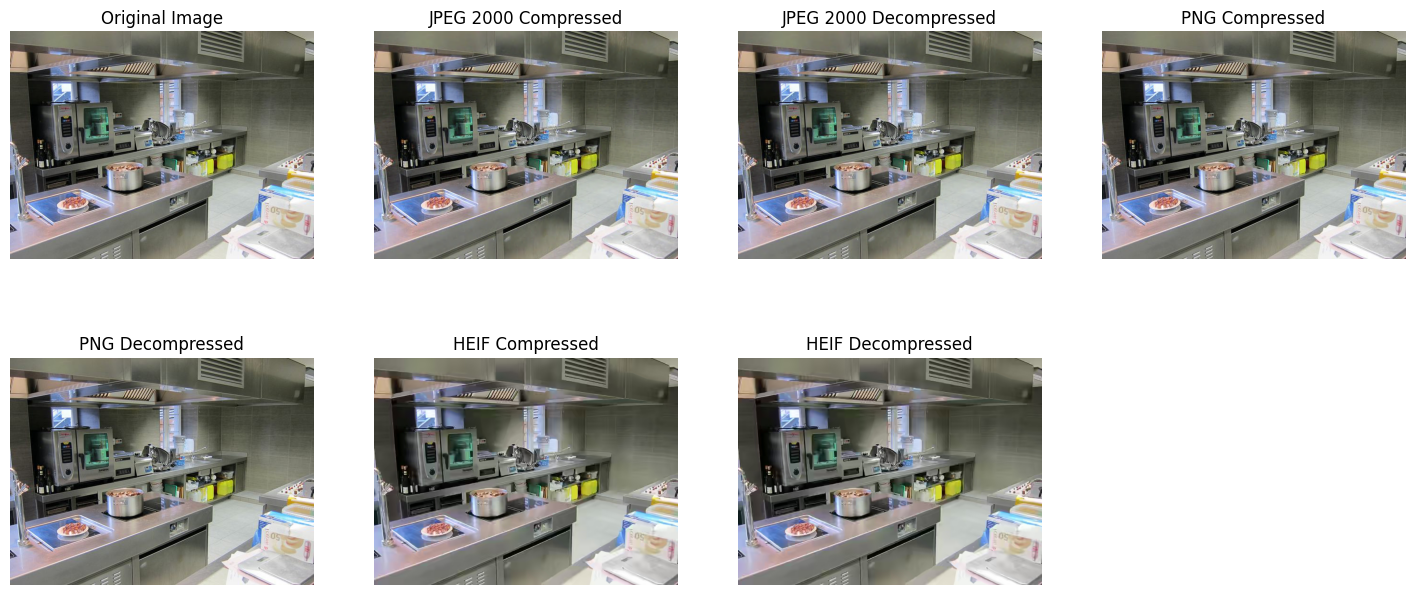

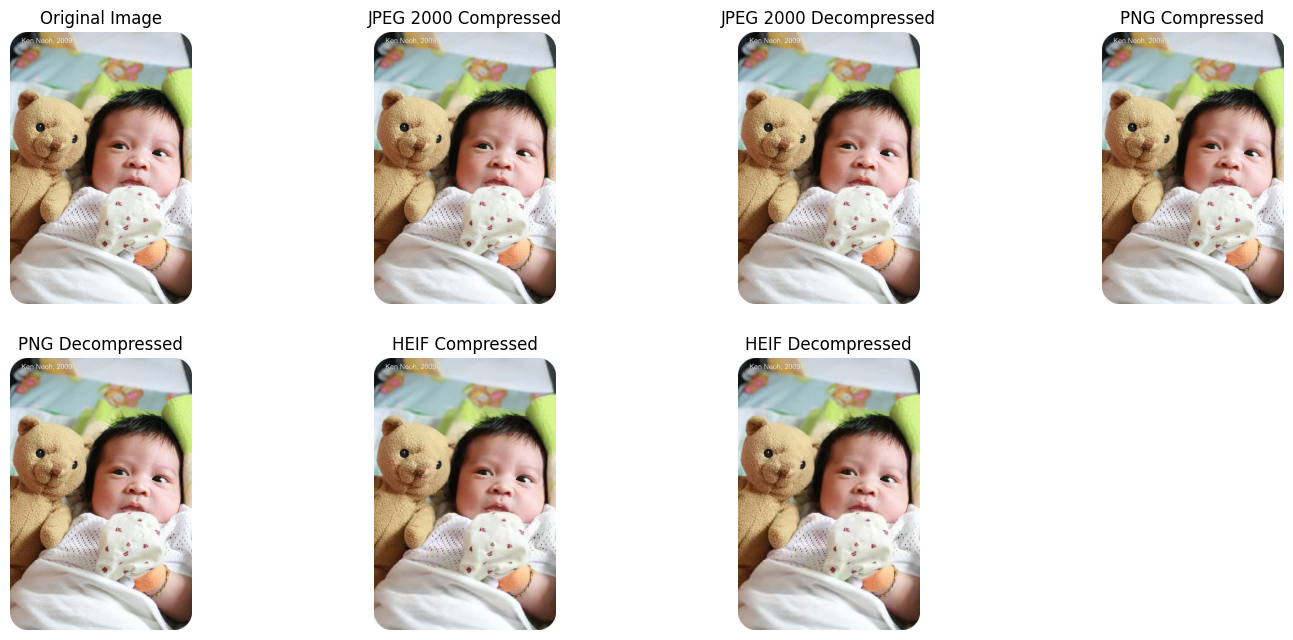

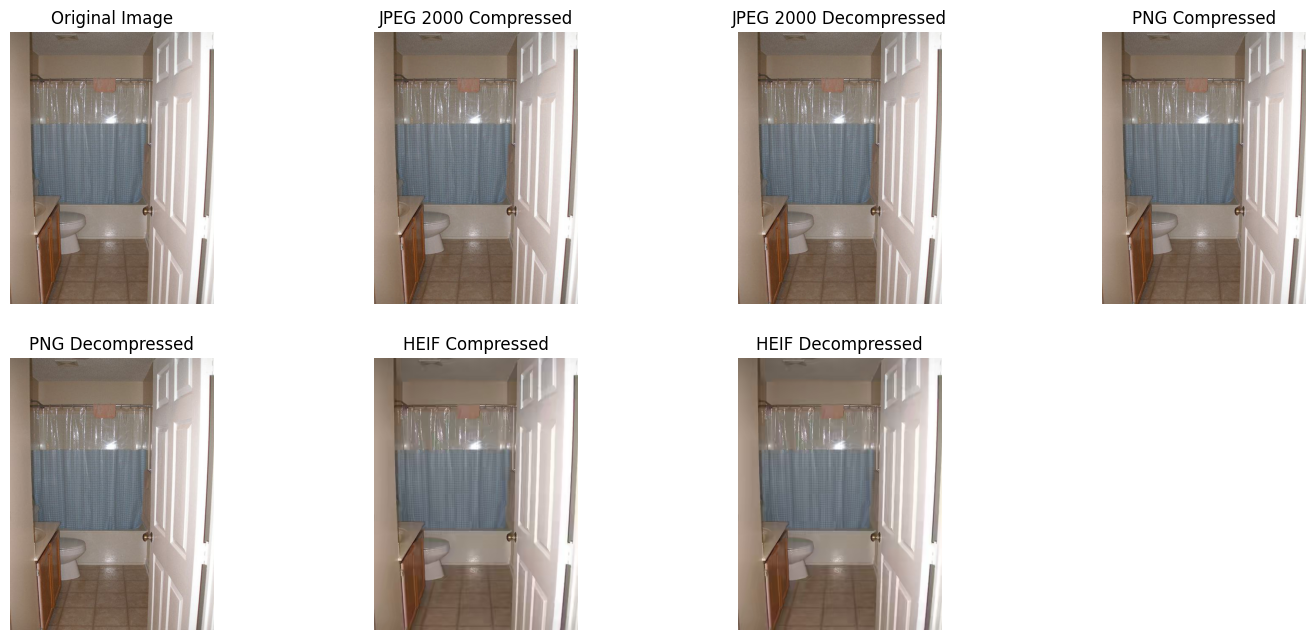

Compression complete
Image 1 - BPP Values: {'JPEG 2000': 4.798515625, 'PNG': 11.096328125, 'HEIF': 0.295}
Image 2 - BPP Values: {'JPEG 2000': 4.79748243559719, 'PNG': 11.370286885245902, 'HEIF': 0.2600995316159251}
Image 3 - BPP Values: {'JPEG 2000': 4.796067708333333, 'PNG': 7.78921875, 'HEIF': 0.15109375}


In [5]:
import imageio
import numpy as np
import io
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import os
import pickle
from pillow_heif import register_heif_opener

register_heif_opener()

image_set = '/content/drive/My Drive/Final Project/datasets/images/'
images = ['COCO_val2014_000000309022.jpg', 'COCO_val2014_000000012448.jpg', 'COCO_val2014_000000326781.jpg']

def compress_image_jp2_in_memory(image_data, quality=25):
    output_buffer = io.BytesIO()
    imageio.imwrite(output_buffer, image_data, 'JPEG2000-PIL', compression=quality)
    return output_buffer

def decompress_image_jp2_from_memory(image_buffer):
    image_buffer.seek(0)
    decompressed_image = imageio.imread(image_buffer, 'JPEG2000-PIL')
    return decompressed_image

def compress_image_png_in_memory(image_data):
    output_buffer = io.BytesIO()
    imageio.imwrite(output_buffer, image_data, 'PNG')
    return output_buffer

def decompress_image_png_from_memory(image_buffer):
    image_buffer.seek(0)
    decompressed_image = imageio.imread(image_buffer, 'PNG')
    return decompressed_image

def compress_image_heif_in_memory(image_data, quality=25):
    output_buffer = io.BytesIO()
    image = Image.fromarray(image_data)
    image.save(output_buffer, format='HEIF', quality=quality)
    return output_buffer

def decompress_image_heif_from_memory(image_buffer):
    image_buffer.seek(0)
    decompressed_image = Image.open(image_buffer)
    return np.array(decompressed_image)

def pickle_size_of(obj):
    return len(pickle.dumps(obj))

uploaded = files.upload()

bpp_vals = []

for image_path in images:
    original_image = imageio.imread(image_set + image_path)
    height, width, _ = original_image.shape

    jp2_buffer = compress_image_jp2_in_memory(original_image, quality=25)
    jp2_compressed = jp2_buffer.getvalue()
    jp2_size_bytes = pickle_size_of(jp2_compressed)
    jp2_bpp = (jp2_size_bytes * 8) / (height * width)
    jp2_decompressed_image = decompress_image_jp2_from_memory(jp2_buffer)

    png_buffer = compress_image_png_in_memory(original_image)
    png_compressed = png_buffer.getvalue()
    png_size_bytes = pickle_size_of(png_compressed)
    png_bpp = (png_size_bytes * 8) / (height * width)
    png_decompressed_image = decompress_image_png_from_memory(png_buffer)

    heif_buffer = compress_image_heif_in_memory(original_image, quality=25)
    heif_compressed = heif_buffer.getvalue()
    heif_size_bytes = pickle_size_of(heif_compressed)
    heif_bpp = (heif_size_bytes * 8) / (height * width)
    heif_decompressed_image = decompress_image_heif_from_memory(heif_buffer)

    plt.figure(figsize=(18, 12))

    plt.subplot(3, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(jp2_decompressed_image)
    plt.title('JPEG 2000 Compressed')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(jp2_decompressed_image)
    plt.title('JPEG 2000 Decompressed')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(png_decompressed_image)
    plt.title('PNG Compressed')
    plt.axis('off')

    plt.subplot(3, 4, 5)
    plt.imshow(png_decompressed_image)
    plt.title('PNG Decompressed')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(heif_decompressed_image)
    plt.title('HEIF Compressed')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(heif_decompressed_image)
    plt.title('HEIF Decompressed')
    plt.axis('off')

    plt.show()

    bpp_vals.append({
        'JPEG 2000': jp2_bpp,
        'PNG': png_bpp,
        'HEIF': heif_bpp
    })

print("Compression complete")
for i, bpp in enumerate(bpp_vals):
    print(f"Image {i+1} - BPP Values: {bpp}")


Inference time for JPEG2000

Inference times for JPEG, PNG, and HEIF

In [ ]:
import os
import time
import imageio
import io
from PIL import Image
from pillow_heif import register_heif_opener

register_heif_opener()

path = "/content/drive/My Drive/Final Project/datasets/images"
images = os.listdir(path)

image_counts = [1, 5, 25, 50, 100]
times_jpeg2000 = {}
times_heif = {}
times_png = {}

def process_images(compression_format, compression_param, times_dict):
    for count in image_counts:
        start_time = time.time()

        for i, image_path in enumerate(images[:count]):
            full_image_path = os.path.join(path, image_path)
            original_image = imageio.imread(full_image_path)

            output_buffer = io.BytesIO()
            if compression_format == 'HEIF':
                image = Image.fromarray(original_image)
                image.save(output_buffer, format='HEIF', quality=compression_param)
            else:
                imageio.imwrite(output_buffer, original_image, compression_format, compression=compression_param)

            compressed = output_buffer.getvalue() 
            output_buffer.seek(0)

        end_time = time.time()
        total_time = end_time - start_time
        times_dict[count] = total_time
        print(f"Processed {count} images in {total_time:.2f} seconds using {compression_format}.")

process_images('JPEG2000-PIL', 25, times_jpeg2000)
process_images('HEIF', 25, times_heif)
process_images('PNG', None, times_png)

print("\nJPEG 2000:")
for count, total_time in times_jpeg2000.items():
    print(f"Time to process {count} images: {total_time:.2f} seconds")

print("\nHEIF:")
for count, total_time in times_heif.items():
    print(f"Time to process {count} images: {total_time:.2f} seconds")

print("\nPNG:")
for count, total_time in times_png.items():
    print(f"Time to process {count} images: {total_time:.2f} seconds")


<ipython-input-14-18c18be4795c>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(full_image_path)


Processed 1 images in 0.41 seconds using JPEG2000-PIL.
Processed 5 images in 1.86 seconds using JPEG2000-PIL.
Processed 25 images in 19.74 seconds using JPEG2000-PIL.
Processed 50 images in 94.79 seconds using JPEG2000-PIL.
Processed 100 images in 28.85 seconds using JPEG2000-PIL.
Processed 1 images in 0.34 seconds using HEIF.
Processed 5 images in 2.59 seconds using HEIF.
Processed 25 images in 12.04 seconds using HEIF.
Processed 50 images in 19.53 seconds using HEIF.
Processed 100 images in 42.84 seconds using HEIF.
Processed 1 images in 0.05 seconds using PNG.
Processed 5 images in 0.41 seconds using PNG.
Processed 25 images in 2.78 seconds using PNG.
Processed 50 images in 6.03 seconds using PNG.
Processed 100 images in 15.78 seconds using PNG.

JPEG 2000:
Time to process 1 images: 0.41 seconds
Time to process 5 images: 1.86 seconds
Time to process 25 images: 19.74 seconds
Time to process 50 images: 94.79 seconds
Time to process 100 images: 28.85 seconds

HEIF:
Time to process 1 im

Inference time for cheng2020anchor

In [ ]:
import os
import time
import torch
from compressai.zoo import cheng2020_anchor
from PIL import Image
import numpy as np

path = "/content/drive/My Drive/2023-24/6.8300/Final Project/datasets/images"
images = os.listdir(path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = cheng2020_anchor(quality=4, pretrained=True).eval().to(device)

image_counts = [1, 5, 25, 50, 100]
times = {}

for count in image_counts:
    start_time = time.time()

    for i, image_path in enumerate(images[:count]):
        full_image_path = os.path.join(path, image_path)
        img = Image.open(full_image_path).convert('RGB')

        img = img.resize((256, 256))
        img = np.array(img).astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)

        with torch.no_grad():
            img = img.to(device)
            out_enc = model.compress(img)

        out_dec = model.decompress(out_enc['strings'], out_enc['shape'])

        reconstructed_image = out_dec['x_hat'].clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
        reconstructed_image = (reconstructed_image * 255).astype(np.uint8)
        img_decompressed = Image.fromarray(reconstructed_image)

    end_time = time.time()
    total_time = end_time - start_time
    times[count] = total_time
    print(f"Processed {count} images in {total_time:.2f} seconds.")

for count, total_time in times.items():
    print(f"Time to process {count} images: {total_time:.2f} seconds")

Processed 1 images in 6.23 seconds.
Processed 5 images in 25.18 seconds.
Processed 25 images in 140.54 seconds.
Processed 50 images in 269.91 seconds.
Processed 100 images in 521.44 seconds.
Time to process 1 images: 6.23 seconds
Time to process 5 images: 25.18 seconds
Time to process 25 images: 140.54 seconds
Time to process 50 images: 269.91 seconds
Time to process 100 images: 521.44 seconds
